# pyfit demo

## Autograd engine

In [1]:
from pyfit.engine import Tensor

### Reverse-mode autodiff

In [2]:
x = Tensor(1.0)
z = 2 * x + 2 + x
q = z + z * x
h = z * z
y = h + q + q * x
print(y.data) # 45.0
y.backward()
print(x.grad) # 62.0 (the numerical value of dy/dx)

[[45.]]
[[62.]]


### Computation graph

In [3]:
# pip install graphviz
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    nodes, edges = trace(root)
    dot = Digraph(format='png')
    
    for n in nodes:
        dot.node(name=str(id(n)), label = f"{{ data {n.data} | grad {n.grad} }}", shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

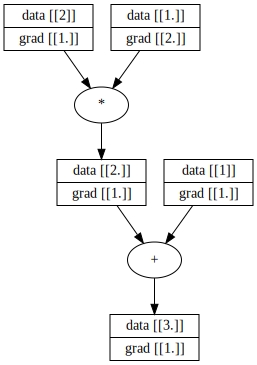

In [4]:
x = Tensor(1.0)
y = (x * 2 + 1)
y.backward()
draw_dot(y)

## Neural network API

### Single neuron

In [5]:
import random
from pyfit.nn import Neuron

random.seed(1337)
n = Neuron(2, activation='sigmoid')
print(n)
print(n.parameters())

<function sigmoid at 0x7f12ac10a3a0> Neuron(2)
[Tensor(data=[[-0.77301144]
 [ 0.02718706]], grad=[[0.]
 [0.]]), Tensor(data=[[0.09566028]], grad=[[0.]])]


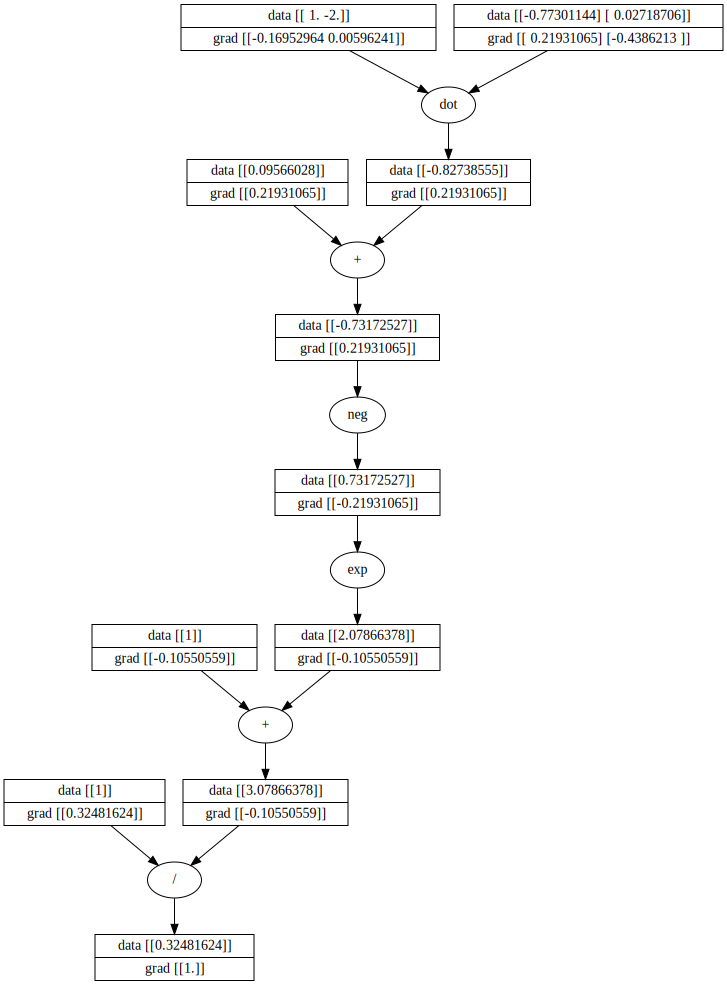

In [6]:
n.zero_grad()
x = Tensor([1.0, -2.0])
y = n(x)
y.backward()
draw_dot(y)

### Learning a line: y = 2 * x + 1

In [7]:
from pyfit.engine import Tensor
from pyfit.nn import Sequential, Dense
from pyfit.optim import SGD
from pyfit.loss import mean_squared_error
from pyfit.train import Trainer
from pyfit.data import BatchIterator

inputs = Tensor([[x] for x in range(10)])
targets = Tensor([[2*x+1] for x in range(10)])

n = Neuron(1, activation='linear')
optimizer = SGD(n.parameters(), learning_rate=0.01)

for epoch in range(100):
    optimizer.zero_grad()
    epoch_loss = 0
    for i in range(10):
        output = n(inputs[i])
        loss = mean_squared_error(output, targets[i])
        epoch_loss += loss.data[0, 0]
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"epoch: {epoch}, loss: {epoch_loss}, w: {n.w.data[0,0]}, b: {n.b.data[0,0]}")
print(f"w: {n.w.data[0,0]}, b: {n.b.data[0,0]}")

epoch: 0, loss: 238.3456595985225, w: 1.2462316179635473, b: 1.9241214874259096
epoch: 10, loss: 0.04563790133237497, w: 1.9806854826725222, b: 1.0713269907215752
epoch: 20, loss: 7.724880304938386e-05, w: 1.9992054122405087, b: 1.0029344457082252
epoch: 30, loss: 1.3074460529547351e-07, w: 1.9999673105299893, b: 1.0001207235751195
epoch: 40, loss: 2.2128694689713758e-10, w: 1.9999986551498714, b: 1.000004966587571
epoch: 50, loss: 3.745310400617336e-13, w: 1.9999999446726464, b: 1.0000002043262228
epoch: 60, loss: 6.338986004658411e-16, w: 1.9999999977238239, b: 1.0000000084060146
epoch: 70, loss: 1.0728795362272537e-18, w: 1.9999999999063582, b: 1.0000000003458247
epoch: 80, loss: 1.8158917047690903e-21, w: 1.999999999996148, b: 1.000000000014227
epoch: 90, loss: 3.072998387172815e-24, w: 1.9999999999998417, b: 1.0000000000005842
w: 1.999999999999991, b: 1.0000000000000329


### Learning XOR

In [8]:
inputs = Tensor([[0, 0], [0, 1], [1, 0], [1, 1]])
targets = Tensor([[0], [1], [1], [0]])

print(inputs.shape)
print(targets.shape)

(4, 2)
(4, 1)


In [9]:
model = Sequential()
model.add(Dense(2, 4, activation='sigmoid'))
model.add(Dense(4, 1, activation='sigmoid'))
print(model)
print(f"Number of parameters: {len(model.parameters())}")

MLP of [Layer of <function sigmoid at 0x7f12ac10a3a0> Neurons(2), Layer of <function sigmoid at 0x7f12ac10a3a0> Neurons(4)]
Number of parameters: 4


In [10]:
optimizer = SGD(model.parameters(), learning_rate=0.1)
loss = mean_squared_error
batch = BatchIterator(inputs, targets, batch_size=4, shuffle=True)

trainer = Trainer(model, optimizer, loss)
_ = trainer.fit(batch, num_epochs=10000, verbose=True)

model(inputs)

Epoch [1/10000], loss: 0.253208, accuracy: 50.00%
Epoch [11/10000], loss: 0.252126, accuracy: 50.00%
Epoch [21/10000], loss: 0.251461, accuracy: 50.00%
Epoch [31/10000], loss: 0.251052, accuracy: 50.00%
Epoch [41/10000], loss: 0.250799, accuracy: 50.00%
Epoch [51/10000], loss: 0.250640, accuracy: 50.00%
Epoch [61/10000], loss: 0.250538, accuracy: 50.00%
Epoch [71/10000], loss: 0.250470, accuracy: 50.00%
Epoch [81/10000], loss: 0.250422, accuracy: 50.00%
Epoch [91/10000], loss: 0.250387, accuracy: 50.00%
Epoch [101/10000], loss: 0.250360, accuracy: 50.00%
Epoch [111/10000], loss: 0.250337, accuracy: 50.00%
Epoch [121/10000], loss: 0.250317, accuracy: 50.00%
Epoch [131/10000], loss: 0.250298, accuracy: 50.00%
Epoch [141/10000], loss: 0.250281, accuracy: 50.00%
Epoch [151/10000], loss: 0.250264, accuracy: 50.00%
Epoch [161/10000], loss: 0.250248, accuracy: 50.00%
Epoch [171/10000], loss: 0.250232, accuracy: 50.00%
Epoch [181/10000], loss: 0.250216, accuracy: 50.00%
Epoch [191/10000], loss

Epoch [1611/10000], loss: 0.247674, accuracy: 50.00%
Epoch [1621/10000], loss: 0.247645, accuracy: 50.00%
Epoch [1631/10000], loss: 0.247616, accuracy: 50.00%
Epoch [1641/10000], loss: 0.247586, accuracy: 50.00%
Epoch [1651/10000], loss: 0.247556, accuracy: 50.00%
Epoch [1661/10000], loss: 0.247525, accuracy: 50.00%
Epoch [1671/10000], loss: 0.247495, accuracy: 50.00%
Epoch [1681/10000], loss: 0.247464, accuracy: 50.00%
Epoch [1691/10000], loss: 0.247432, accuracy: 50.00%
Epoch [1701/10000], loss: 0.247400, accuracy: 50.00%
Epoch [1711/10000], loss: 0.247368, accuracy: 50.00%
Epoch [1721/10000], loss: 0.247335, accuracy: 50.00%
Epoch [1731/10000], loss: 0.247302, accuracy: 50.00%
Epoch [1741/10000], loss: 0.247269, accuracy: 50.00%
Epoch [1751/10000], loss: 0.247235, accuracy: 50.00%
Epoch [1761/10000], loss: 0.247201, accuracy: 50.00%
Epoch [1771/10000], loss: 0.247166, accuracy: 50.00%
Epoch [1781/10000], loss: 0.247131, accuracy: 50.00%
Epoch [1791/10000], loss: 0.247096, accuracy: 

Epoch [3161/10000], loss: 0.231463, accuracy: 75.00%
Epoch [3171/10000], loss: 0.231180, accuracy: 75.00%
Epoch [3181/10000], loss: 0.230892, accuracy: 75.00%
Epoch [3191/10000], loss: 0.230600, accuracy: 75.00%
Epoch [3201/10000], loss: 0.230303, accuracy: 75.00%
Epoch [3211/10000], loss: 0.230001, accuracy: 75.00%
Epoch [3221/10000], loss: 0.229694, accuracy: 75.00%
Epoch [3231/10000], loss: 0.229383, accuracy: 75.00%
Epoch [3241/10000], loss: 0.229066, accuracy: 75.00%
Epoch [3251/10000], loss: 0.228744, accuracy: 75.00%
Epoch [3261/10000], loss: 0.228416, accuracy: 75.00%
Epoch [3271/10000], loss: 0.228084, accuracy: 75.00%
Epoch [3281/10000], loss: 0.227746, accuracy: 75.00%
Epoch [3291/10000], loss: 0.227402, accuracy: 75.00%
Epoch [3301/10000], loss: 0.227053, accuracy: 75.00%
Epoch [3311/10000], loss: 0.226699, accuracy: 75.00%
Epoch [3321/10000], loss: 0.226338, accuracy: 75.00%
Epoch [3331/10000], loss: 0.225972, accuracy: 75.00%
Epoch [3341/10000], loss: 0.225600, accuracy: 

Epoch [4751/10000], loss: 0.106178, accuracy: 100.00%
Epoch [4761/10000], loss: 0.105196, accuracy: 100.00%
Epoch [4771/10000], loss: 0.104222, accuracy: 100.00%
Epoch [4781/10000], loss: 0.103254, accuracy: 100.00%
Epoch [4791/10000], loss: 0.102292, accuracy: 100.00%
Epoch [4801/10000], loss: 0.101338, accuracy: 100.00%
Epoch [4811/10000], loss: 0.100391, accuracy: 100.00%
Epoch [4821/10000], loss: 0.099451, accuracy: 100.00%
Epoch [4831/10000], loss: 0.098518, accuracy: 100.00%
Epoch [4841/10000], loss: 0.097592, accuracy: 100.00%
Epoch [4851/10000], loss: 0.096674, accuracy: 100.00%
Epoch [4861/10000], loss: 0.095763, accuracy: 100.00%
Epoch [4871/10000], loss: 0.094859, accuracy: 100.00%
Epoch [4881/10000], loss: 0.093963, accuracy: 100.00%
Epoch [4891/10000], loss: 0.093075, accuracy: 100.00%
Epoch [4901/10000], loss: 0.092194, accuracy: 100.00%
Epoch [4911/10000], loss: 0.091321, accuracy: 100.00%
Epoch [4921/10000], loss: 0.090455, accuracy: 100.00%
Epoch [4931/10000], loss: 0.

Epoch [6271/10000], loss: 0.029658, accuracy: 100.00%
Epoch [6281/10000], loss: 0.029467, accuracy: 100.00%
Epoch [6291/10000], loss: 0.029278, accuracy: 100.00%
Epoch [6301/10000], loss: 0.029091, accuracy: 100.00%
Epoch [6311/10000], loss: 0.028905, accuracy: 100.00%
Epoch [6321/10000], loss: 0.028722, accuracy: 100.00%
Epoch [6331/10000], loss: 0.028540, accuracy: 100.00%
Epoch [6341/10000], loss: 0.028360, accuracy: 100.00%
Epoch [6351/10000], loss: 0.028182, accuracy: 100.00%
Epoch [6361/10000], loss: 0.028006, accuracy: 100.00%
Epoch [6371/10000], loss: 0.027832, accuracy: 100.00%
Epoch [6381/10000], loss: 0.027659, accuracy: 100.00%
Epoch [6391/10000], loss: 0.027488, accuracy: 100.00%
Epoch [6401/10000], loss: 0.027319, accuracy: 100.00%
Epoch [6411/10000], loss: 0.027151, accuracy: 100.00%
Epoch [6421/10000], loss: 0.026985, accuracy: 100.00%
Epoch [6431/10000], loss: 0.026821, accuracy: 100.00%
Epoch [6441/10000], loss: 0.026658, accuracy: 100.00%
Epoch [6451/10000], loss: 0.

Epoch [7841/10000], loss: 0.013603, accuracy: 100.00%
Epoch [7851/10000], loss: 0.013551, accuracy: 100.00%
Epoch [7861/10000], loss: 0.013500, accuracy: 100.00%
Epoch [7871/10000], loss: 0.013449, accuracy: 100.00%
Epoch [7881/10000], loss: 0.013398, accuracy: 100.00%
Epoch [7891/10000], loss: 0.013348, accuracy: 100.00%
Epoch [7901/10000], loss: 0.013297, accuracy: 100.00%
Epoch [7911/10000], loss: 0.013248, accuracy: 100.00%
Epoch [7921/10000], loss: 0.013198, accuracy: 100.00%
Epoch [7931/10000], loss: 0.013149, accuracy: 100.00%
Epoch [7941/10000], loss: 0.013100, accuracy: 100.00%
Epoch [7951/10000], loss: 0.013052, accuracy: 100.00%
Epoch [7961/10000], loss: 0.013004, accuracy: 100.00%
Epoch [7971/10000], loss: 0.012956, accuracy: 100.00%
Epoch [7981/10000], loss: 0.012909, accuracy: 100.00%
Epoch [7991/10000], loss: 0.012861, accuracy: 100.00%
Epoch [8001/10000], loss: 0.012814, accuracy: 100.00%
Epoch [8011/10000], loss: 0.012768, accuracy: 100.00%
Epoch [8021/10000], loss: 0.

Epoch [9431/10000], loss: 0.008269, accuracy: 100.00%
Epoch [9441/10000], loss: 0.008247, accuracy: 100.00%
Epoch [9451/10000], loss: 0.008226, accuracy: 100.00%
Epoch [9461/10000], loss: 0.008205, accuracy: 100.00%
Epoch [9471/10000], loss: 0.008184, accuracy: 100.00%
Epoch [9481/10000], loss: 0.008163, accuracy: 100.00%
Epoch [9491/10000], loss: 0.008142, accuracy: 100.00%
Epoch [9501/10000], loss: 0.008121, accuracy: 100.00%
Epoch [9511/10000], loss: 0.008101, accuracy: 100.00%
Epoch [9521/10000], loss: 0.008080, accuracy: 100.00%
Epoch [9531/10000], loss: 0.008060, accuracy: 100.00%
Epoch [9541/10000], loss: 0.008039, accuracy: 100.00%
Epoch [9551/10000], loss: 0.008019, accuracy: 100.00%
Epoch [9561/10000], loss: 0.007999, accuracy: 100.00%
Epoch [9571/10000], loss: 0.007979, accuracy: 100.00%
Epoch [9581/10000], loss: 0.007959, accuracy: 100.00%
Epoch [9591/10000], loss: 0.007939, accuracy: 100.00%
Epoch [9601/10000], loss: 0.007919, accuracy: 100.00%
Epoch [9611/10000], loss: 0.

Tensor(data=[[0.0886721 ]
 [0.91691171]
 [0.91726628]
 [0.08462912]], grad=[[0.]
 [0.]
 [0.]
 [0.]])